## Podcast Reviews
This analysis is based on a dataset of over 2 million podcast reviews for 100k podcasts on itunes in the US, between 2005 and 2023. Find the data here: https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28

We can ask ourselves the following questions based on the data above:

* How many reviews does a podcast get on average? And what is the average rating score per podcast?
* Which categories have most reviews and/or podcasts, and which are highgest rated?
* How are the amount of reviews, podcasts and average rating differing over the years?
* Is there a relation between amount of reviews and average rating?

If wanting to dive deeper into category/year level data, you can use this [dashboard](https://lookerstudio.google.com/reporting/1868b3da-f6c9-4913-bce3-90613320b13c/page/p_p0d8qtyjpc ).



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
import warnings
import sqlite3
import statsmodels.api as sm
from scipy import stats
import random

warnings.filterwarnings("ignore")

In [2]:
sns.set_style("white")
sns.set_palette("ch:.25")
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [5]:
path = "/content/drive/MyDrive/colab_data_sources/database.sqlite"
connection = sqlite3.connect(path)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1: Data Pre-processing

#### Podcast data

In [6]:
query_podcasts = """
SELECT * FROM podcasts
"""
podcasts = pd.read_sql_query(query_podcasts, connection)

In [7]:
podcasts.head()

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,139076942,mystery-dancing-in-the-dark,https://podcasts.apple.com/us/podcast/mystery-...,Mystery: Dancing in the Dark
3,a00071f9aaae9ac725c3a586701abf4d,1332508972,kts-money-matters,https://podcasts.apple.com/us/podcast/kts-mone...,KTs Money Matters
4,a000a500f06555f81220c3eb641aded7,1544900779,word-on-the-street-w-dreak-swift,https://podcasts.apple.com/us/podcast/word-on-...,Word on the Street w/ Dreak Swift


In [8]:
podcasts.nunique()

podcast_id    110024
itunes_id     110024
slug          108919
itunes_url    110024
title         109274
dtype: int64

Printing out the amount of unique values for the features in the podcasts table, we can see that there are 3 unique identifiers. The 'slug' basically looks like a cleaned version of the title column, however what seems strange is that the amount of unique values differs between these two columns. There are about 350 less unique slugs than titles.

In [9]:
podcasts.isna().sum()

podcast_id    0
itunes_id     0
slug          0
itunes_url    0
title         0
dtype: int64

In [10]:
podcasts["us"] = np.where(podcasts["itunes_url"].str.contains("/us/"), 1, 0)
podcasts[podcasts["us"] == 0]

,podcast_id,itunes_id,slug,itunes_url,title,us


All url's contain /us/ countrycode, thus different countrycodes inside the url could not explain the above differences in unique amounts. And we cannot analyse differences by country.

In [11]:
podcasts["apple"] = np.where(podcasts["itunes_url"].str.contains("apple"), 1, 0)
podcasts[podcasts["apple"] == 0]

,podcast_id,itunes_id,slug,itunes_url,title,us,apple


Only data of Apple is included.

#### Review data

In [12]:
query_reviews = """
SELECT *
FROM reviews
LIMIT 5
"""
reviews = pd.read_sql_query(query_reviews, connection)
reviews

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00


* From the first few rows printed above, we notice there is no review_id or otherwise unique key per review.  
* We can check how many unique podcast_id's there are in the review table, to find out whether this matches the podcast table, and which proportion of podcasts got reviewed.
* We will not import the whole table as a dataframe as it is too heavy for that.

In [13]:
query_review_prop = """
SELECT
COUNT(DISTINCT podcast_id) AS nr_podcasts,
COUNT(podcast_id) AS nr_reviews
FROM reviews
"""
prop_reviews = pd.read_sql_query(query_review_prop, connection)
prop_reviews

,nr_podcasts,nr_reviews
0,111544,2067529


In [14]:
query_review_prop = """
SELECT COUNT(DISTINCT podcast_id) AS nr_podcasts,
COUNT(podcast_id) AS nr_reviews
FROM reviews
WHERE podcast_id IN (
  SELECT DISTINCT podcast_id
  FROM podcasts
)
"""
prop_reviews = pd.read_sql_query(query_review_prop, connection)
prop_reviews

,nr_podcasts,nr_reviews
0,110024,2043297


There seem to be 1520 more unique podcast_id's with 24k more reviews in the review table than in the podcasts table.
The podcast_id's that are in the podcast table are all found back in the reviews table, as we checked above. However, there are some extra podcasts in the review table, we will take a look at those below.

In [15]:
query_non_matching_ids = """
SELECT DISTINCT r.podcast_id, title, content, rating, author_id, created_at
FROM reviews r
WHERE r.podcast_id NOT IN (
  SELECT DISTINCT podcast_id
  FROM categories
)
"""
ids_not_matching = pd.read_sql_query(query_non_matching_ids, connection)
ids_not_matching.sort_values("created_at", ascending=False).head(25)

,podcast_id,title,content,rating,author_id,created_at
24217,d6ebfabb551ad91e98bf005bb3c3f827,The show has gone downhill,I’ve been listing to this show for three years...,1,E9093445255F873,2023-01-18T20:17:42-07:00
24219,eb5cfb8360db010444accda22e99cad9,She’s the best!!,She won me over with Deadly women! I just watc...,5,83387D8F76F0DCE,2023-01-02T23:33:00-07:00
24221,ad9adfec5393242a72d07321b719d9d7,Real B energy!,Sam is literally as real as it gets. And that’...,5,97B27DF00EC8E41,2022-12-28T06:25:15-07:00
24216,d6ebfabb551ad91e98bf005bb3c3f827,Best show ever,I Loved the Christmas Eve show. I always feel ...,5,AE1A452F03BCF9F,2022-12-24T16:21:57-07:00
24210,ecee758965defa18861e92c7a410122b,Misspellings and inaccuracies,"Not fond of the show. Also, a lot of fluff and...",3,2975ECC1C888139,2022-12-24T10:19:20-07:00
24218,de4cf1ece1ead7516a2aa07b3cd5af0e,Identity in Christ,"You bring glory to God, you are a blessing to me.",5,E2EF352A6286837,2022-12-22T06:45:51-07:00
24220,ad9adfec5393242a72d07321b719d9d7,My weekly dose of fierce,Listening to Sam vulnerably (and unapologetica...,5,35EC5B370F8354B,2022-12-15T13:58:39-07:00
24206,d47a2e2c046fa9292fa2d47292d15072,Good ECHL Content,"I like the ECHL episodes, but please learn how...",4,63926F62D2E44DC,2022-12-10T22:18:53-07:00
24222,ad9adfec5393242a72d07321b719d9d7,Truly inspiring !!!,If I had to use one-two words to describe how ...,5,DB6B2BE19F08BF9,2022-12-09T07:03:05-07:00
24211,a7df827825d8fb24344aabe73d556660,You asked for this,HAAAAAAAA-P-P-P-P-P-P-P-P-P-P-P-PYYYYYYYY BIII...,5,A56AE764AB0F35D,2022-12-08T09:39:59-07:00


At first sight nothing looks wrong or invalid about these cases, thus we don't filter them out.

In [16]:
query_rating_check = """
SELECT rating
FROM reviews
WHERE rating NOT IN (1,2,3,4,5)
"""
rating_check = pd.read_sql_query(query_rating_check, connection)
rating_check

,rating


In [17]:
rating_check.count()

rating    0
dtype: int64

The rating feature seems to not contain any other values than numbers 1 to 5 as values, and thus no cleaning needs to be done on this feature.

In [18]:
query_daterange = """
SELECT
MIN(strftime('%m-%Y', created_at)) AS first_month,
MAX(strftime('%m-%Y', created_at)) AS last_month,
COUNT(created_at) AS non_missing_dates
FROM reviews
"""
date_range = pd.read_sql_query(query_daterange, connection)
date_range

,first_month,last_month,non_missing_dates
0,01-2006,12-2022,2067529


The date range spans 17 complete years, thus we can do year-over-year comparison.

#### Category data

In [19]:
query_categories = """
SELECT category,
COUNT(podcast_id) AS nr_of_podcasts
FROM categories
GROUP BY 1
ORDER BY 2 DESC
"""
categories = pd.read_sql_query(query_categories, connection)
categories

,category,nr_of_podcasts
0,society-culture,18710
1,education,12628
2,comedy,12464
3,religion-spirituality,12190
4,business,12058
...,...,...
105,sports-swimming,18
106,science-physics,18
107,science-chemistry,17
108,science-mathematics,16


* There are 110 different categories, however there is no unique identifier other than the name of the category. The table only contains the podcast_id, we could wonder if that's unique.
* We might wonder whether there exist higher level and sub categories in this table, as we see several sports- and science- categories.

In [20]:
categories.sort_values(["category"]).head(25)

,category,nr_of_podcasts
5,arts,8953
21,arts-books,1978
62,arts-design,596
59,arts-fashion-beauty,610
40,arts-food,1074
23,arts-performing-arts,1805
38,arts-visual-arts,1137
96,buddhism,141
4,business,12058
18,business-careers,2445


It looks like there are some kind of (super)categories and subcategories under it. The supercategory counts look like aggregates. Now we could wonder whether some podcasts are twice in this table, once under the super and once under the sub category, or even under multiple supercategories.

In [21]:
query_categories_totals = """
SELECT
COUNT(DISTINCT podcast_id) AS unique_nr_of_podcasts,
COUNT(podcast_id) AS nr_of_podcasts
FROM categories
"""
totals = pd.read_sql_query(query_categories_totals, connection)
totals

,unique_nr_of_podcasts,nr_of_podcasts
0,110024,212372


In [22]:
query_categories_totals = """
SELECT
COUNT(DISTINCT podcast_id) AS unique_nr_of_podcasts
FROM categories
WHERE podcast_id IN (
  SELECT podcast_id
  FROM podcasts
)
"""
totals_check = pd.read_sql_query(query_categories_totals, connection)
totals_check

,unique_nr_of_podcasts
0,110024


It looks like there are a lot more cases (about 100k) in the category table than unique podcast_id's, meaning there will be podcasts that fall under different categories and/or sub and main categories. This is important for us to know, because if we want to compare category means, we need to be comparing independent (mutually exclusive) samples, which is not the case for the categories above.
The number of unique podcast_id's here however matches that of the podcasts table, and all the id's are found back in both tables, meaning all podcasts in the podcasts table are categorised.




In [23]:
query_category_reviews = """
SELECT
r.podcast_id,
category,
strftime('%Y', created_at) AS year
FROM categories c
JOIN reviews r
ON c.podcast_id = r.podcast_id
"""
category_reviews = pd.read_sql_query(
    query_category_reviews, connection, index_col="category"
)
category_reviews

,podcast_id,year
category,,
arts,c61aa81c9b929a66f0c1db6cbe5d8548,2018
arts-performing-arts,c61aa81c9b929a66f0c1db6cbe5d8548,2018
music,c61aa81c9b929a66f0c1db6cbe5d8548,2018
arts,c61aa81c9b929a66f0c1db6cbe5d8548,2018
arts-performing-arts,c61aa81c9b929a66f0c1db6cbe5d8548,2018
...,...,...
business-careers,ec0898451fd6b961c42beceaeec43648,2023
fiction,ebc36287c28e63f458d55fd2a25e6658,2022
fiction-drama,ebc36287c28e63f458d55fd2a25e6658,2022


Above as an example, the first podcast_id is categorised in 3 different ways, during the same year. We will take the first category for each podcast_id and work with, as below, to avoid many-to-many joins on podcast_id with the review table later on.  

In [24]:
query_category = """
SELECT
distinct podcast_id,
min(category) as cat
FROM categories
group by 1
"""
categories = pd.read_sql_query(query_category, connection)

## Part 2: Exploratory Analysis
Above we found out that our sample consists of reviews and ratings of podcasts, streamed from itunes US,between 2005 and 2023.

### Podcast level
* How many reviews on average does a podcast get?


##### Reviews per podcast

In [25]:
query_reviews = """
WITH totals AS (
  SELECT
  ROW_number() OVER (ORDER BY created_at) AS id,
  podcast_id,
  COUNT(*) OVER () AS total
FROM reviews
)
SELECT
podcast_id,
COUNT(id) as nr_of_reviews,
CAST(COUNT(id) AS float)/CAST(total AS float) AS prop
FROM totals
GROUP BY podcast_id
ORDER BY 2 desc
"""
reviews_per_podcast = pd.read_sql_query(query_reviews, connection)
reviews_per_podcast[["nr_of_reviews"]].describe()

,nr_of_reviews
count,111544.000
mean,18.536
std,150.174
min,1.000
25%,1.000
50%,3.000
75%,8.000
max,33104.000


In [26]:
total_reviews = reviews_per_podcast["nr_of_reviews"].sum()
print("The total amount of reviews in the dataset is " + str(total_reviews))

The total amount of reviews in the dataset is 2067529


* The total amount of podcasts reviewed is 111544.
* The highest number of reviews received by one podcast is 33104.
* On average, a podcast received 18,5 reviews over the time span of our dataset.
* There is a very high standard deviation of 150. When we look at the quantiles, this makes sense as the overall range is very broad, however 75% of podcasts got 8 or less reviews, and at least 25% of the podcasts only got one review.
* The max will likely be an outlier, and the distribution will be very skewed.

Text(0.5, 1.0, 'Number of reviews per podcast (log scale)')

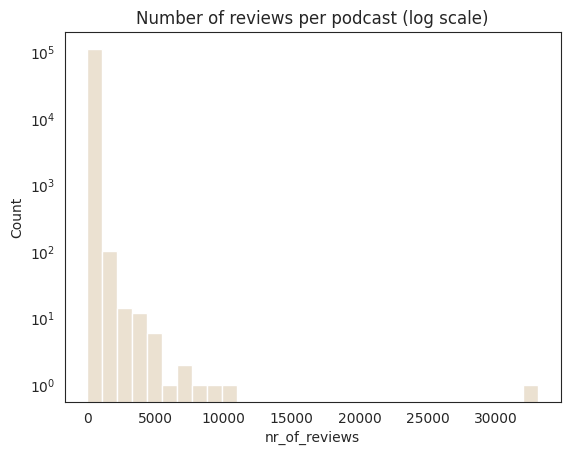

In [27]:
sns.histplot(x=reviews_per_podcast["nr_of_reviews"], bins=30)
plt.yscale("log")
plt.title("Number of reviews per podcast (log scale)")

We can see that, as expected, the podcast with most reviews is clearly an outlier, but without that, the distribution is still right-skewed.

Text(0.5, 1.0, 'Number of reviews per podcast (log scale), outlierfree')

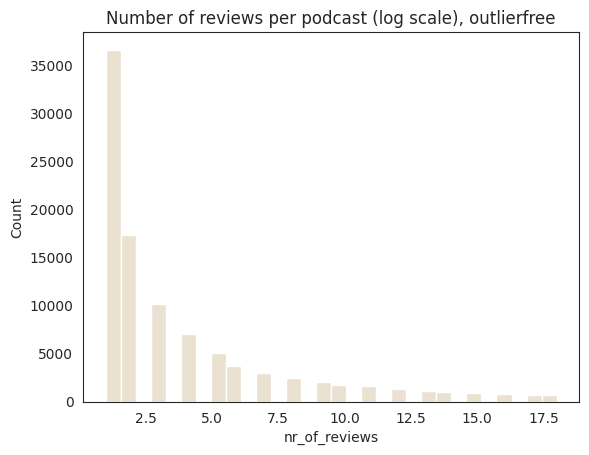

In [28]:
IQR = np.quantile(reviews_per_podcast["nr_of_reviews"], 0.75) - np.quantile(
    reviews_per_podcast["nr_of_reviews"], 0.25
)
upper_range = np.quantile(reviews_per_podcast["nr_of_reviews"], 0.75) + IQR * 1.5
outlierfree_reviews = reviews_per_podcast[
    reviews_per_podcast["nr_of_reviews"] < upper_range
]
sns.histplot(x=outlierfree_reviews["nr_of_reviews"], bins=30)
# plt.yscale('log')
plt.title("Number of reviews per podcast (log scale), outlierfree")

In [29]:
outlierfree_reviews[["nr_of_reviews"]].describe()

,nr_of_reviews
count,97096.000
mean,3.745
std,3.812
min,1.000
25%,1.000
50%,2.000
75%,5.000
max,18.000


* After taking out outliers, the range is just 1-18 reviews per podcast, with a mean of 3.75 reviews per podcast, a drastic change.
* We took out about 14k cases. However, we could doubt whether this is useful since the distribution remains skewed and since our goal is to get insights into popular podcasts/podcast categories, thus the ones that are excluded now.
  


#### Avg rating & proportions
* What does the overall average rating, and proportions of different rating scores look like?

In [30]:
rating_query = """
SELECT rating
FROM reviews
"""
ratings = pd.read_sql_query(rating_query, connection)
ratings.describe()

,rating
count,2067529.000
mean,4.627
std,1.046
min,1.000
25%,5.000
50%,5.000
75%,5.000
max,5.000


* In total there are over 2 million ratings, the same amount as the total number of reviews, as a rating is part of a review.
* The average rating is 4.6, within a range from 1 to 5. The distribution is expected to be heavily left-skewed, Q1 to the max are all 5 star ratings.

We take a look at the distribution graph and proportions below.

In [31]:
query_ratings_prop = """
SELECT rating,
rating_counts,
ROUND(CAST(rating_counts AS float)/CAST(total_ratings AS float), 4) AS prop
FROM (
SELECT rating,
rating_counts,
SUM(rating_counts) OVER () AS total_ratings
FROM (
SELECT rating,
COUNT(*) AS rating_counts
FROM reviews
GROUP BY rating) AS sub ) AS SUBSUB
"""
prop_ratings = pd.read_sql_query(query_ratings_prop, connection, index_col="rating")
prop_ratings

,rating_counts,prop
rating,,
1,116547,0.056
2,45866,0.022
3,52176,0.025
4,62883,0.030
5,1790057,0.866


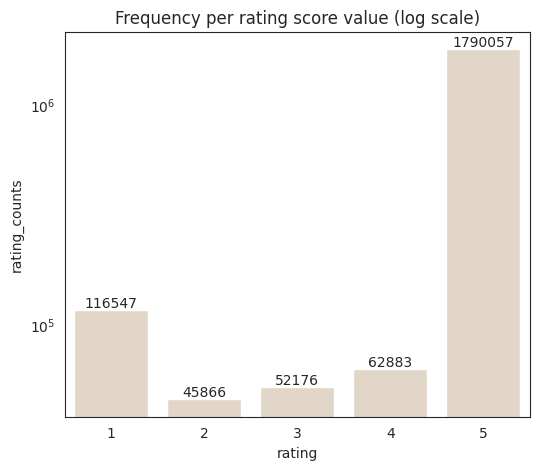

In [32]:
prop_ratings["rating_counts_thousands"] = (prop_ratings["rating_counts"] / 1000).astype(
    int
)
plt.figure(figsize=(6, 5))
ax = sns.barplot(x=prop_ratings.index, y=prop_ratings.rating_counts)
plt.yscale("log")
plt.title("Frequency per rating score value (log scale)")
for i, v in enumerate(prop_ratings["rating_counts"]):
    ax.text(i, v + 1, str(v), ha="center", va="bottom", fontsize=10)

* The far majority of reviews (87%) has a positive 5 star rating.
* There are more 1 star ratings (6%) than any of the middle ratings (2-3%).
* We might wonder whether the proportion of 5 star ratings and average rating score are artificially high, with Apple taking out low rated podcasts. In this case our sample would not be representative, which prevents us from making inferences about population proportions of ratings.


### Category level

#### Podcasts & reviews per category
* Under which categories fall most podcasts?
* Which categories get most reviews overall? And which proportions of total reviews is this?
* Which categories have the highest average number of reviews per podcast?

In [33]:
query_category_reviews = """
WITH categories_clean as (
  SELECT
  DISTINCT podcast_id AS podcast_id,
  MIN(category) AS category
  FROM categories
  GROUP BY 1
),
counted as (
SELECT
category,
COUNT(DISTINCT c.podcast_id) AS nr_of_podcasts,
COUNT(r.podcast_id) AS nr_of_reviews,
AVG(rating) as avg_rating
FROM reviews r
JOIN categories_clean c
ON c.podcast_id = r.podcast_id
GROUP BY 1 )
SELECT
category,
nr_of_podcasts,
nr_of_reviews,
nr_of_reviews/nr_of_podcasts as avg_reviews_podcast,
avg_rating
FROM counted
GROUP BY 1
ORDER BY 3 DESC
"""
category_reviews = pd.read_sql_query(
    query_category_reviews, connection, index_col="category"
)

In [34]:
category_reviews[
    ["nr_of_podcasts", "nr_of_reviews", "avg_reviews_podcast"]
].sort_values(["nr_of_podcasts", "nr_of_reviews"], ascending=False)

,nr_of_podcasts,nr_of_reviews,avg_reviews_podcast
category,,,
comedy,11628,325179,27
business,11552,200829,17
society-culture,10570,200354,18
education,9496,146292,15
arts,8953,136508,15
...,...,...,...
sports-volleyball,8,48,6
sports-swimming,5,21,4
science-chemistry,3,20,6


* There are 110 categories in total. The category 'comedy' has both the highest number of podcasts and most reviews overall.
* The category with second most podcasts and reviews in total is 'business'.
* The comedy category has a higher than average amount of reviews per podcast of 27.
* The categories with the least podcasts were more specific or sub categories.


In [35]:
category_reviews[["nr_of_podcasts", "nr_of_reviews"]].describe()

,nr_of_podcasts,nr_of_reviews
count,110.000,110.000
mean,1000.218,18575.427
std,2508.778,49576.352
min,2.000,3.000
25%,59.000,484.000
50%,104.500,1399.000
75%,170.000,3187.000
max,11628.000,325179.000


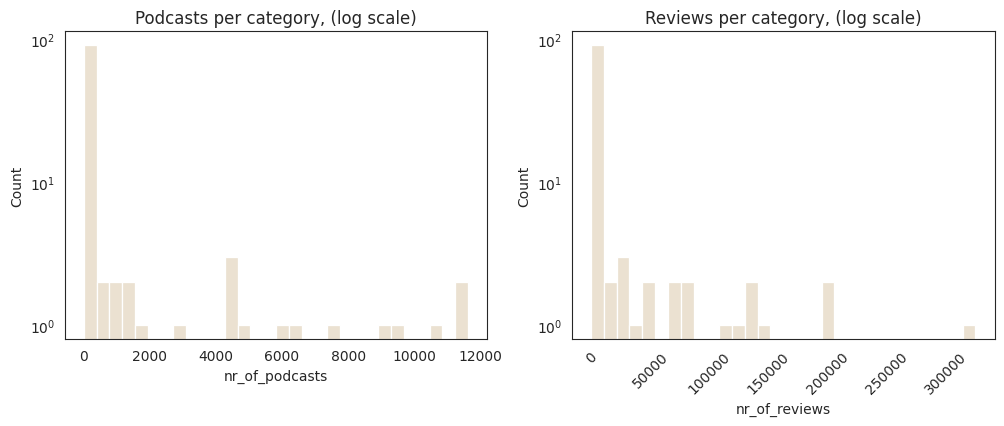

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plt.subplots_adjust(hspace=0.6)
sns.histplot(x=category_reviews["nr_of_podcasts"], ax=axes[0], bins=30)
sns.histplot(x=category_reviews["nr_of_reviews"], ax=axes[1], bins=30)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_title("Podcasts per category, (log scale)")
axes[1].set_title("Reviews per category, (log scale)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45);

* The majority of categories contains a relatively low amount of podcasts. The distribution is clearly right-skewed, the average of 1000 podcasts per category is much higher than both the median and Q3. We can clearly see that there are some outliers.
* For the amount of reviews per category we see a similar pattern, the majority of categories gets a relatively low number of reviews. The difference between median and min is much smaller than between median and max.



#### Average amount of reviews per podcast, per category
* Since the distributions above are so skewed, we will look at the average amount of reviews a podcast gets, and compare categories based on that.

In [37]:
category_reviews[["avg_reviews_podcast"]].describe()

,avg_reviews_podcast
count,110.000
mean,14.309
std,11.763
min,1.000
25%,8.000
50%,12.000
75%,18.750
max,100.000


* The, per category, average amount of reviews a podcast gets is 14.3. Note that this 14 is an average of averages, as our average calculated on the ungrouped data was 18.5.
* The mean and median are not that far apart from each other, however the standard deviation is almost as high as the mean. The max is a clear outlier.
* Below the distribution of average amount of reviews per category, which is much more even than the above two. It is approximating a normal distribution with the mode slightly moved to the left.


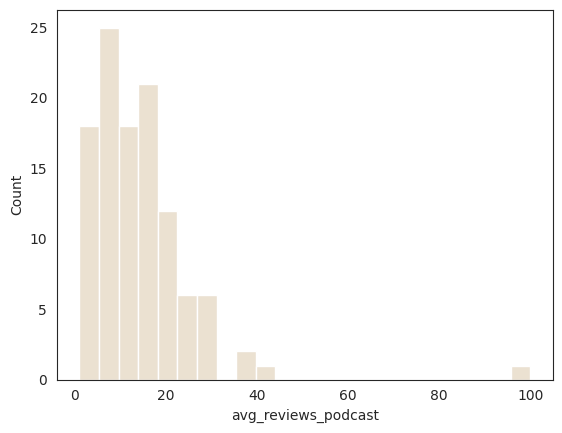

In [107]:
sns.histplot(x=category_reviews["avg_reviews_podcast"])
plt.title("");

In [39]:
category_reviews.sort_values("avg_reviews_podcast", ascending=False).head(10)

,nr_of_podcasts,nr_of_reviews,avg_reviews_podcast,avg_rating
category,,,,
true-crime,731,73278,100,4.220
sports-wilderness,86,3808,44,4.749
sports-football,64,2461,38,4.542
history,1269,46969,37,4.465
leisure-video-games,117,3711,31,4.690
news,4483,138870,30,4.231
health-fitness-fitness,119,3357,28,4.822
comedy,11628,325179,27,4.619
health-fitness-nutrition,84,2340,27,4.889


* The top 5 categories with highest average amounts of reviews per podcast are completely different from the categories with most reviews and most podcasts printed earlier. However two of the latter, comedy and news, are in the top 10.
* Overall, the top 10 is a mix of larger and smaller categories in terms of total amounts of podcasts and reviews.
* We can see that the true-crime category has a far higher average, without it, the max would be 44, and so the overall range in means would be much smaller.
* The average of 100 reviews per podcast is actually based on a lot of podcasts and reviews, thus it seems a truely exceptional category. The average rating of 4.2 is quite low considering the overall mean rating of 4.6



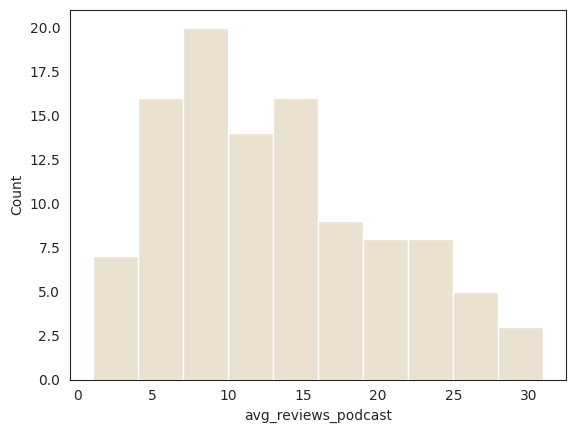

In [108]:
IQR_2 = np.quantile(category_reviews["avg_reviews_podcast"], 0.75) - np.quantile(
    category_reviews["avg_reviews_podcast"], 0.25
)
upper_range_2 = np.quantile(category_reviews["avg_reviews_podcast"], 0.75) + IQR_2 * 1.5

outlier_free = category_reviews[category_reviews["avg_reviews_podcast"] < upper_range_2]
sns.histplot(x=outlier_free["avg_reviews_podcast"], bins=10);

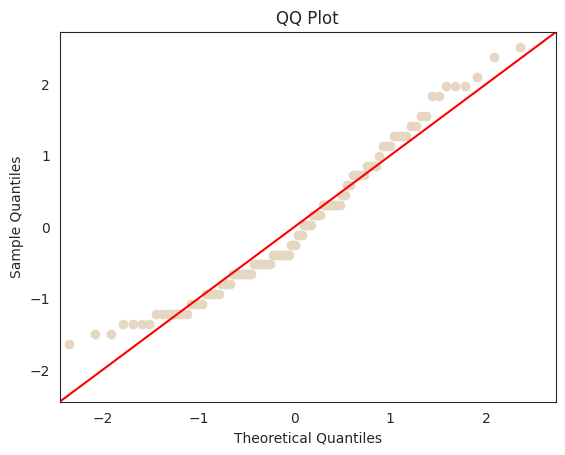

In [41]:
qq_plot = sm.qqplot(outlier_free["avg_reviews_podcast"], line="45", fit=True)
plt.title("QQ Plot")
plt.show(qq_plot)

In [42]:
outlier_free[["avg_reviews_podcast"]].describe()

,avg_reviews_podcast
count,106.000
mean,12.783
std,7.260
min,1.000
25%,7.250
50%,11.000
75%,18.000
max,31.000


Without outliers, the mean is quite a bit lower and the standard deviation as well, looking at the distribution graph and qqplot, we can now assume the average amount of reviews per category is normally distributed.

Apart from the average amount of reviews per podcast, what we are also curious about the average podcast rating per category.

#### Avg ratings per category
* How do average ratings per category differ between categories?

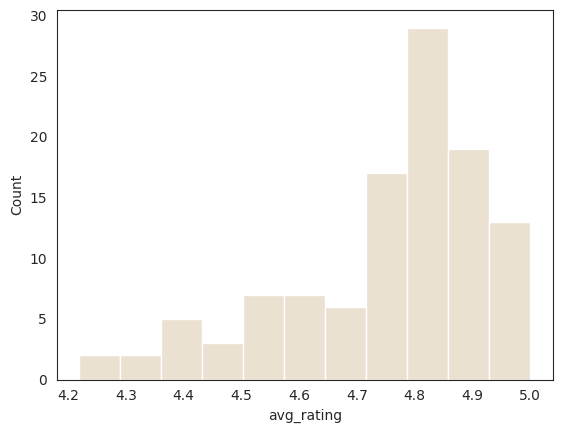

In [109]:
sns.histplot(x=category_reviews["avg_rating"]);

The per category average ratings scores are ranging from 4.2 to 5.  

In [44]:
category_reviews[["avg_rating", "nr_of_reviews", "avg_reviews_podcast"]].sort_values(
    "avg_rating", ascending=False
).head(10)

,avg_rating,nr_of_reviews,avg_reviews_podcast
category,,,
science-mathematics,5.000,3,1
sports-rugby,5.000,31,2
business-non-profit,4.961,356,3
education-self-improvement,4.959,2391,21
science-social-sciences,4.957,208,4
kids-family-pets-animals,4.956,228,4
science-earth-sciences,4.955,88,4
business-entrepreneurship,4.941,6163,27
tv-film-film-interviews,4.939,472,10


* The categories with the highest average ratings are all (sub)categories with relatively low amounts of reviews, considering the average number of reviews a category gets is 18.5k.    
* Looking at average rating scores for the most reviewed categories below, it seems like the amount of reviews and the average rating per category aren't necessarily moving in a pattern.

In [45]:
category_avg_ratings = (
    category_reviews[["avg_rating", "nr_of_reviews", "avg_reviews_podcast"]]
    .iloc[0:5, :]
    .round(2)
)
category_avg_ratings

,avg_rating,nr_of_reviews,avg_reviews_podcast
category,,,
comedy,4.620,325179,27
business,4.840,200829,17
society-culture,4.420,200354,18
education,4.810,146292,15
news,4.230,138870,30


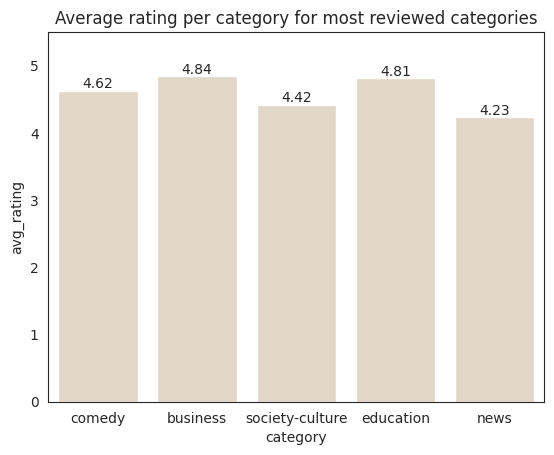

In [46]:
ax = sns.barplot(x=category_avg_ratings.index, y=category_avg_ratings["avg_rating"])
ax.set_title("Average rating per category for most reviewed categories")
ax.set_ylim(0, 5.5)
for i, v in enumerate(category_avg_ratings["avg_rating"]):
    ax.text(i, v, str(v), ha="center", va="bottom", fontsize=10);

At first sight, the differences in average ratings seem minor, however we could wonder whether these are meaningful, and whether they are related to the amount of reviews a category gets.

#### Correlations
* Is there any relation between amount of reviews a category gets and average rating score?


In [47]:
def corplot(dataframe):
    plt.figure(figsize=(5, 4))
    corr_matrix = dataframe.corr().round(2)
    sns.heatmap(corr_matrix, annot=True)

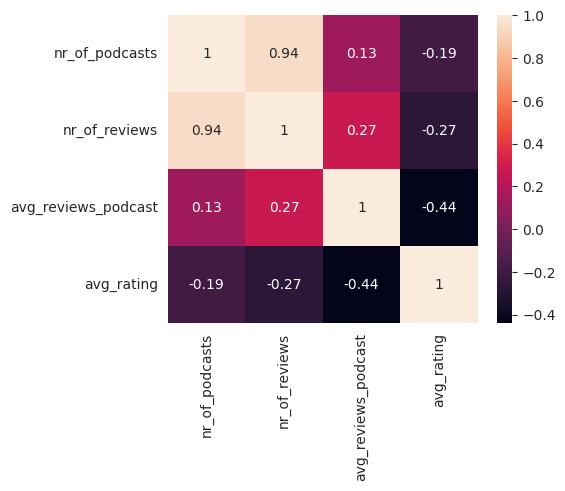

In [48]:
corplot(category_reviews)

 * The total amount of reviews goes up when there are more podcasts in a category, which makes sense intuitively. However, average amount of reviews per podcast only has a weak correlation both with amount of podcasts and reviews.  
* Total amount of podcasts and total reviews are slightly negatively related to the average rating score of a category.
* The higher the average amount of reviews per podcast in a category, the lower the average rating tends to be, and vice versa. However this correlation is also quite weak -0.34.

#### Proportions of 5 star ratings
* How do rating distributions differ between the most reviewed categories?
* Which proportion of reviews has a 5 star rating? And which a 1 star rating?


In [49]:
query_topcategory_ratings = """
WITH categories_clean as (
  SELECT
  DISTINCT podcast_id AS podcast_id,
  MIN(category) AS category
  FROM categories
  GROUP BY 1
),
ratings as (
  SELECT
category,
rating,
COUNT(*) AS counts
FROM categories_clean c
JOIN reviews r
ON r.podcast_id = c.podcast_id
WHERE category IN ('society-culture', 'comedy', 'education', 'business', 'news')
GROUP BY 1,2
), ratings_two as (
SELECT
category,
rating,
counts,
SUM(counts) OVER (PARTITION BY category) AS cat_nr_ratings
FROM ratings)
SELECT
category,
rating,
counts AS nr_of_ratings,
cat_nr_ratings AS total_cat_ratings,
CAST(counts as float)/cast(cat_nr_ratings AS float) AS prop
FROM ratings_two
"""
category_ratings = pd.read_sql_query(
    query_topcategory_ratings, connection, index_col="category"
)

In [50]:
five_star_ratings = category_ratings[category_ratings["rating"] == 5]
five_star_ratings[["rating", "nr_of_ratings", "prop"]].sort_values(
    "prop", ascending=False
)

,rating,nr_of_ratings,prop
category,,,
business,5,188514,0.939
education,5,134996,0.923
comedy,5,282707,0.869
society-culture,5,160072,0.799
news,5,102949,0.741


In [51]:
one_star_ratings = category_ratings[category_ratings["rating"] == 1]
one_star_ratings[["rating", "nr_of_ratings", "prop"]].sort_values(
    "prop", ascending=False
)

,rating,nr_of_ratings,prop
category,,,
news,1,17705,0.127
society-culture,1,17753,0.089
comedy,1,20187,0.062
education,1,3842,0.026
business,1,4798,0.024


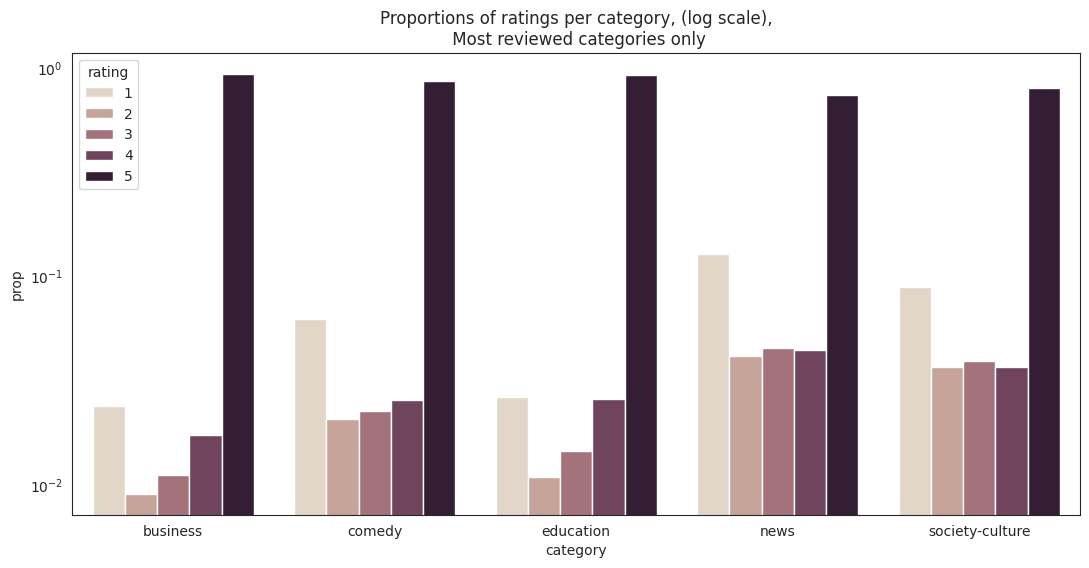

In [52]:
fig = plt.figure(figsize=(13, 6))
sns.barplot(
    x=category_ratings.index,
    y=category_ratings["prop"],
    hue=category_ratings["rating"],
    palette="ch:.25",
)
plt.title(
    "Proportions of ratings per category, (log scale),\n Most reviewed categories only"
)
plt.yscale("log");

We can see that the distribution of rating scores is overall very similar, with for each category the majority of ratings being 5 star ratings, and 1 star ratings second largest. For the news category, the differences in proportions are smallest, while for business, the highest and lowest rating proportions are furthest away from each other percentagewise.  
Now we can wonder whether these differences in the proportions of 5 star ratings are meaningful.

### Time Series Analysis


#### Year over year
* How are the total amounts of podcasts reviewed, total reviews and average rating scores differing over the years?

In [53]:
query_date_reviews = """
WITH categories_clean as (
  SELECT
  DISTINCT podcast_id AS podcast_id,
  MIN(category) AS category
  FROM categories
  GROUP BY 1
)
SELECT
strftime('%Y', created_at) AS year,
COUNT(*) AS nr_reviews,
COUNT(DISTINCT c.podcast_id) AS nr_podcasts,
AVG(rating) as avg_rating
FROM reviews r
JOIN categories_clean c
ON c.podcast_id = r.podcast_id
GROUP BY 1
"""
date_reviews = pd.read_sql_query(query_date_reviews, connection)
date_reviews = date_reviews.dropna()

In [54]:
date_reviews.describe()

,nr_reviews,nr_podcasts,avg_rating
count,19.000,19.000,19.000
mean,107541.842,11678.053,4.648
std,141368.889,13962.296,0.113
min,192.000,78.000,4.437
25%,11567.000,2230.000,4.574
50%,24600.000,4203.000,4.618
75%,168495.000,19012.000,4.755
max,433998.000,42683.000,4.816


On average, there are 108k reviews done per year over 11678 podcasts per year. The actual numbers of reviews and podcasts vary a lot between years, as we can see from the high standard deviations and from the graphs below.  

In [55]:
def barplot(yvar, title):
    plt.figure(figsize=(9, 5))
    ax = sns.barplot(x=date_reviews["year"], y=date_reviews[yvar], palette="ch:.25")
    plt.gcf().autofmt_xdate()
    plt.title(title)
    for i, v in enumerate(date_reviews[yvar]):
        ax.text(i, v, str(v), ha="center", va="bottom", fontsize=8)

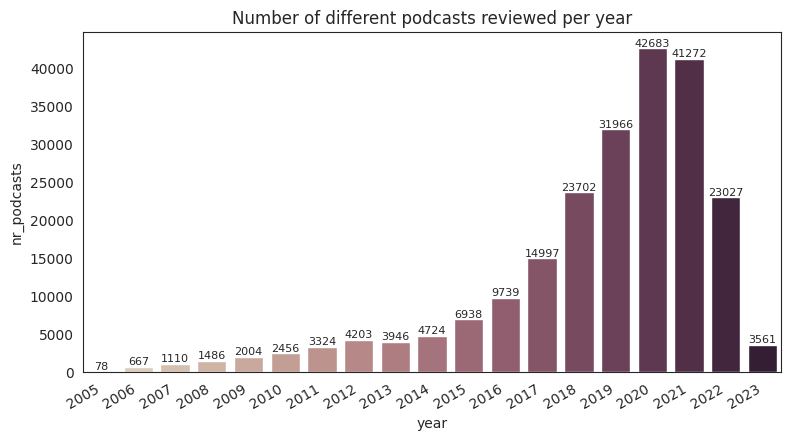

In [56]:
barplot("nr_podcasts", "Number of different podcasts reviewed per year")

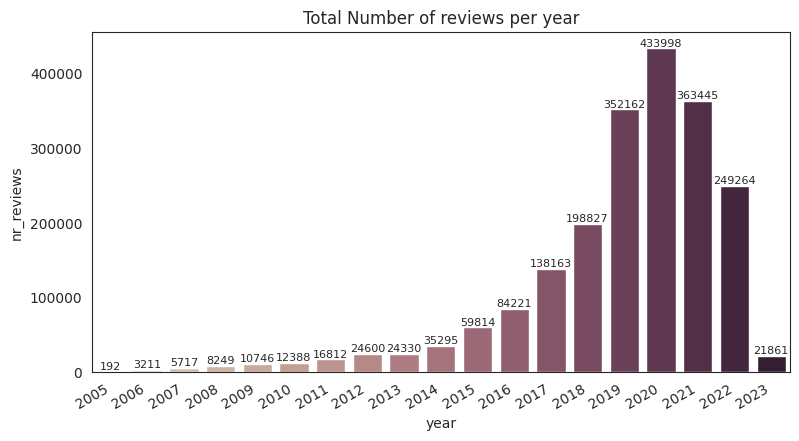

In [57]:
barplot("nr_reviews", "Total Number of reviews per year")

* During the first 10 years, the numbers of reviews and podcasts reviewed increase at a much slower rate than from 2015 on. Then after 2020, numbers of reviews start declining.
* 2020 was the year in which most podcast reviews were done.
* What we can see also is that both the number of podcasts reviewed and the total amount of reviews over the years, are left-skewed normal distributions. Just in 2013 and in 2022 there are slight deviations from the pattern. Thus, we might wonder whether the average amount of reviews per podcast substantially differed in these years.

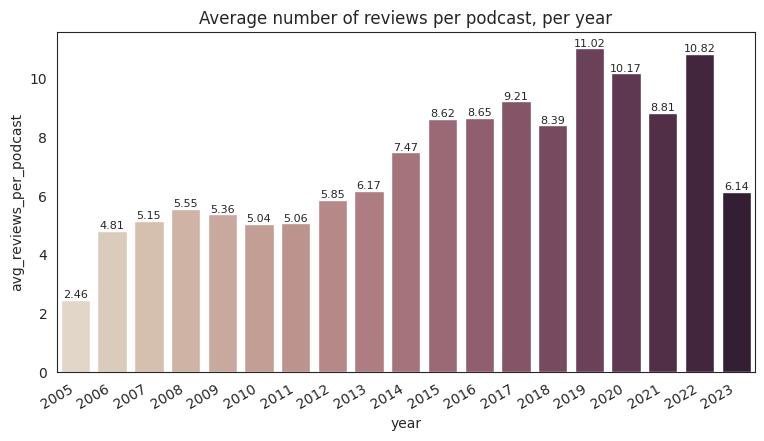

In [110]:
date_reviews["avg_reviews_per_podcast"] = (
    date_reviews["nr_reviews"] / date_reviews["nr_podcasts"]
).round(
    2)

barplot("avg_reviews_per_podcast", "Average number of reviews per podcast, per year")

Even though 2020 was the year with most reviewed podcasts and total most reviews, the average amount of reviews per podcast was not the highest.
The average seems to roughly go up over the years, with some ups and downs in between.

In [59]:
date_reviews[["avg_reviews_per_podcast"]].describe()

,avg_reviews_per_podcast
count,19.000
mean,7.092
std,2.360
min,2.460
25%,5.255
50%,6.170
75%,8.730
max,11.020


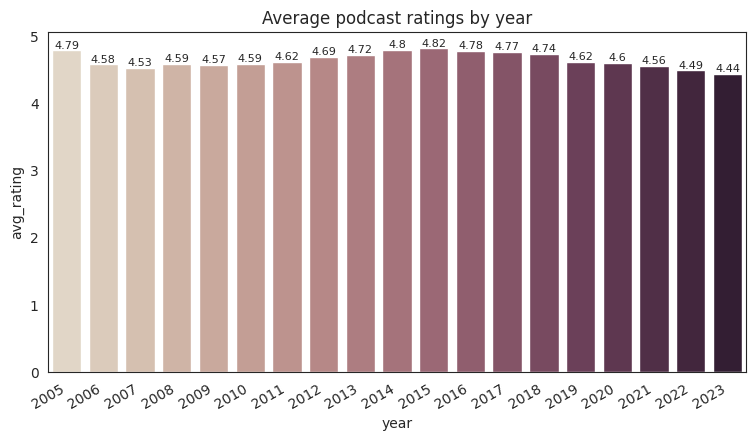

In [60]:
date_reviews["avg_rating"] = date_reviews["avg_rating"].round(2)
barplot("avg_rating", "Average podcast ratings by year")

* The overall average rating was highest in 2015, and lowest in 2023. Thus 2015 seems a key point both in podcast and review volume, as well as in average rating score.
We might wonder why the average rating has been decreasing since 2015.

* We could divide the dataset into 2 and analyse trends separately, before 2015 and from 2015, as the trend reverses there.



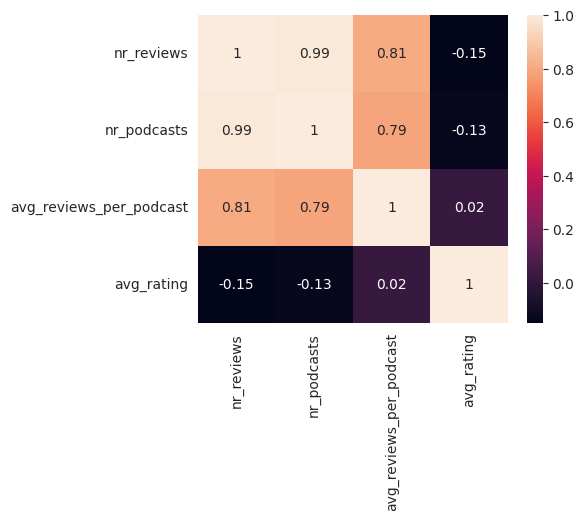

In [61]:
corplot(
    date_reviews[["nr_reviews", "nr_podcasts", "avg_reviews_per_podcast", "avg_rating"]]
)

Overall there are weak negative correlations between number of reviews and podcast, and average rating.  

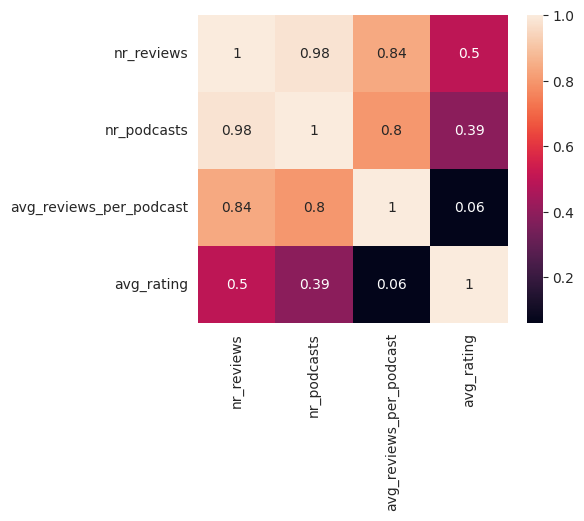

In [62]:
date_reviews["year"] = date_reviews["year"].astype(int)
earlier_years = date_reviews[date_reviews["year"] < 2015]
later_years = date_reviews[date_reviews["year"] > 2014]
corplot(
    earlier_years[
        ["nr_reviews", "nr_podcasts", "avg_reviews_per_podcast", "avg_rating"]
    ]
)

* Looking at years before 2015, there is a positive correlation between number of reviews and number of podcasts and average rating, after 2014 this turns around and becomes a negative correlation.
* Thus it seems like in a year with more reviews, the average rating score is likely to be higher, however this holds true up to 2015, then more reviews seem to be related to lower average rating.
* The average amount of reviews per podcast has no correlation with the average rating score, not even when splitting up the dataset.

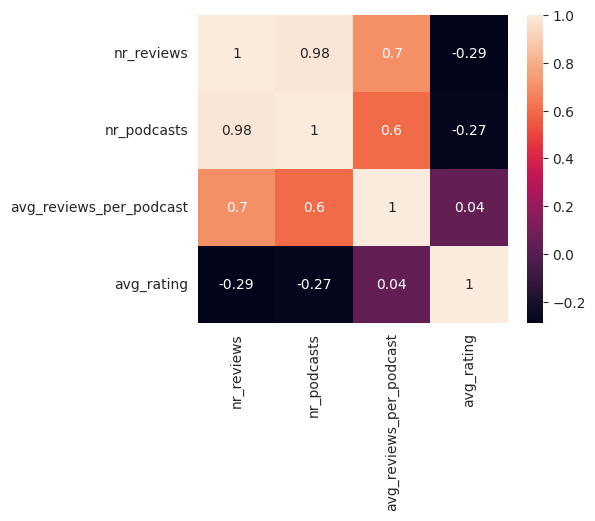

In [63]:
corplot(
    later_years[["nr_reviews", "nr_podcasts", "avg_reviews_per_podcast", "avg_rating"]]
)

#### Categories by year
* Are category options the same each year, or does the amount of categories differ between years?
* Was the category with most postcasts also the one with most reviews each year?
* How does average rating of categories change over time?


In [64]:
query_category_year_ranked = """
WITH categories_clean as (
  SELECT
  DISTINCT podcast_id AS podcast_id,
  min(category) AS category
  FROM categories
  GROUP BY 1
), sub AS (
SELECT
category,
strftime('%Y', created_at) AS year,
COUNT(DISTINCT c.podcast_id) AS nr_podcasts,
COUNT(c.podcast_id) AS nr_of_reviews,
AVG(rating) as avg_rating
FROM categories_clean c
JOIN reviews r
ON c.podcast_id = r.podcast_id
WHERE created_at IS NOT NULL
GROUP BY 1,2
)
SELECT
category,
year,
nr_podcasts,
RANK() OVER (PARTITION BY year ORDER BY nr_podcasts DESC) AS nr_of_podcasts_rank,
nr_of_reviews,
RANK() OVER (PARTITION BY year ORDER BY nr_of_reviews DESC) AS nr_of_reviews_rank,
nr_of_reviews/nr_podcasts AS avg_reviews_podcast,
avg_rating,
RANK() OVER (PARTITION BY year ORDER BY avg_rating DESC) AS avg_rating_rank
FROM sub
ORDER BY 4 DESC
"""
years_ranked = pd.read_sql_query(query_category_year_ranked, connection)
years_ranked = years_ranked.dropna()

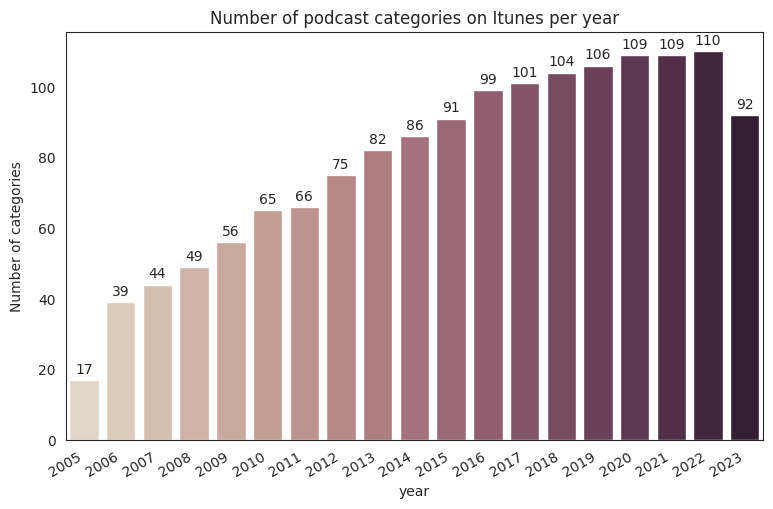

In [65]:
categories_peryear = years_ranked.groupby("year")[["category"]].nunique()
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    x=categories_peryear.index, y=categories_peryear["category"], palette="ch:.25"
)
plt.gcf().autofmt_xdate()
plt.title("Number of podcast categories on Itunes per year")
plt.ylabel("Number of categories")
for i, v in enumerate(categories_peryear["category"]):
    ax.text(i, v + 1, str(v), ha="center", va="bottom", fontsize=10)

The amount of categories has been increasing steadily over the years, and pretty much stabilized in 2020.

In [66]:
years_ranked[years_ranked["nr_of_podcasts_rank"] == 1].sort_values(
    "year", ascending=False
).head(10)

,category,year,nr_podcasts,nr_of_podcasts_rank,nr_of_reviews,nr_of_reviews_rank,avg_reviews_podcast,avg_rating,avg_rating_rank
1500,comedy,2023,400,1,3320,1,8,4.398,74
1499,business,2022,2382,1,18154,4,7,4.764,67
1498,business,2021,4772,1,32419,3,6,4.799,47
1497,business,2020,4944,1,40148,3,8,4.822,49
1496,comedy,2019,4106,1,63662,1,15,4.649,78
1495,comedy,2018,3188,1,30814,1,9,4.766,70
1494,comedy,2017,2056,1,20519,1,9,4.809,61
1493,comedy,2016,1242,1,12709,1,10,4.792,63
1492,comedy,2015,837,1,8569,2,10,4.821,57
1491,comedy,2014,559,1,5703,1,10,4.799,50


* Comedy has been the category with most podcasts for the last 10 years, except the 3 years before 2023 in which business was the category with most podcasts.
* These 10 years, except for those 3 years and 2015, it has also been the most reviewed category.
* The average rating of this category has been relatively low all these years, however we saw earlier in the correlation analysis that the amount of reviews is negatively correlated with average rating, thus this makes sense.
* In earlier years, christianity, music and arts have been the most reviewed categories.

In [67]:
years_ranked[years_ranked["nr_of_reviews_rank"] == 1].sort_values(
    "year", ascending=False
).head(10)

,category,year,nr_podcasts,nr_of_podcasts_rank,nr_of_reviews,nr_of_reviews_rank,avg_reviews_podcast,avg_rating,avg_rating_rank
1500,comedy,2023,400,1,3320,1,8,4.398,74
1460,comedy,2022,1742,3,34880,1,20,4.393,98
1459,comedy,2021,3820,3,55984,1,14,4.561,91
1458,comedy,2020,4257,3,73270,1,17,4.555,91
1496,comedy,2019,4106,1,63662,1,15,4.649,78
1495,comedy,2018,3188,1,30814,1,9,4.766,70
1494,comedy,2017,2056,1,20519,1,9,4.809,61
1493,comedy,2016,1242,1,12709,1,10,4.792,63
1434,business,2015,683,4,10520,1,15,4.927,34
1491,comedy,2014,559,1,5703,1,10,4.799,50


Since 2011, comedy has been te most reviewed category with only 2015 as exception.
In 2015 business was the most reviewed category, with a higher average rating than the most reviewed categories in later years.
Since Business was the largest category in terms of podcasts since 2020, we might wonder how business is doing over the years compared to comedy.

In [68]:
years_ranked[years_ranked["avg_rating_rank"] == 1].sort_values("year", ascending=False)

,category,year,nr_podcasts,nr_of_podcasts_rank,nr_of_reviews,nr_of_reviews_rank,avg_reviews_podcast,avg_rating,avg_rating_rank
418,sports-golf,2023,3,60,8,56,2,5.000,1
242,sports-tennis,2023,2,74,3,75,1,5.000,1
711,arts-fashion-beauty,2023,6,40,19,41,3,5.000,1
712,business-management,2023,6,40,12,48,2,5.000,1
713,religion,2023,6,40,12,48,2,5.000,1
...,...,...,...,...,...,...,...,...,...
1305,buddhism,2005,2,10,3,12,1,5.000,1
1306,sports,2005,2,10,3,12,1,5.000,1
1307,health-fitness,2005,2,10,2,14,1,5.000,1
1308,religion-spirituality,2005,2,10,2,14,1,5.000,1


From the above we can see there were 289 year-category combinations where the category only received 5 star ratings, however based on a relatively low amounts of ratings.

In [69]:
top_categories = years_ranked.query(
    "category == 'comedy'|category == 'business'|category == 'news'|category == 'education'|category == 'society-culture'"
).sort_values("year")

In [70]:
def lineplot_grouped(x, y, hue):
    plt.figure(figsize=(13, 5))
    sns.lineplot(x=top_categories[x], y=top_categories[y], hue=top_categories[hue])
    plt.gcf().autofmt_xdate()

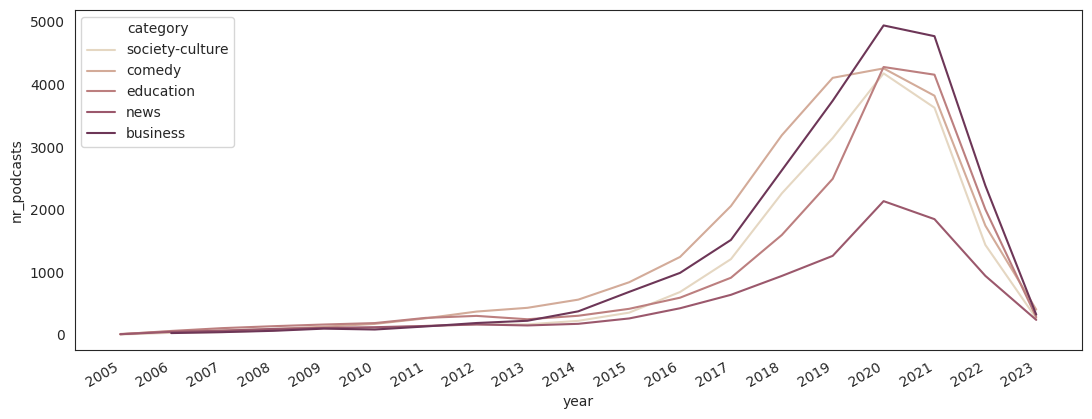

In [71]:
lineplot_grouped("year", "nr_podcasts", "category")

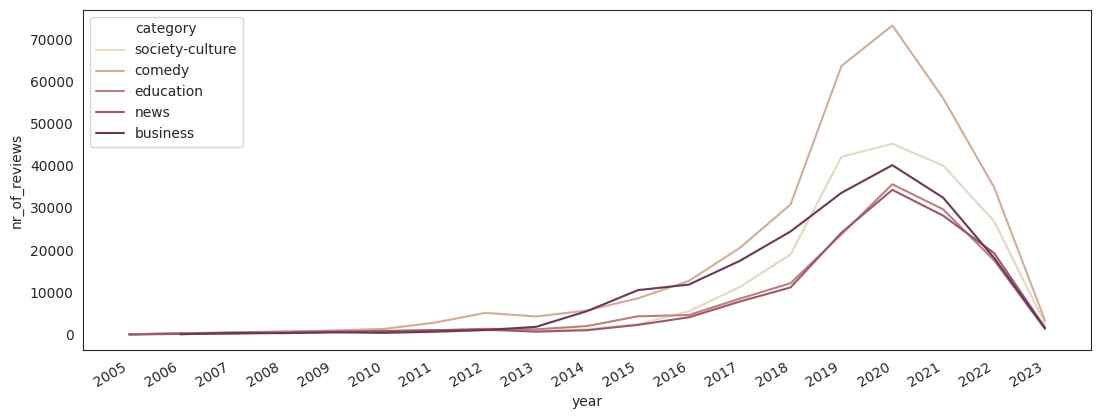

In [72]:
lineplot_grouped("year", "nr_of_reviews", "category")

* The comedy category is almost consistently highest in amount of reviews it received. Until 2019 it is also having most podcasts, from 2020 business has the most.
* We notice slow growth from 2005 to 2015, after which the growth trend becomes much steeper.
* The peak in 2020 and downward trend does not seems to be a general pattern, and not something that could be explained by changes in a specific category.  
* We might wonder whether the average amount of reviews per category is a better comparison metric.
* We might wonder whether in the first 10 years the most popular categories were completely different ones than the ones above.

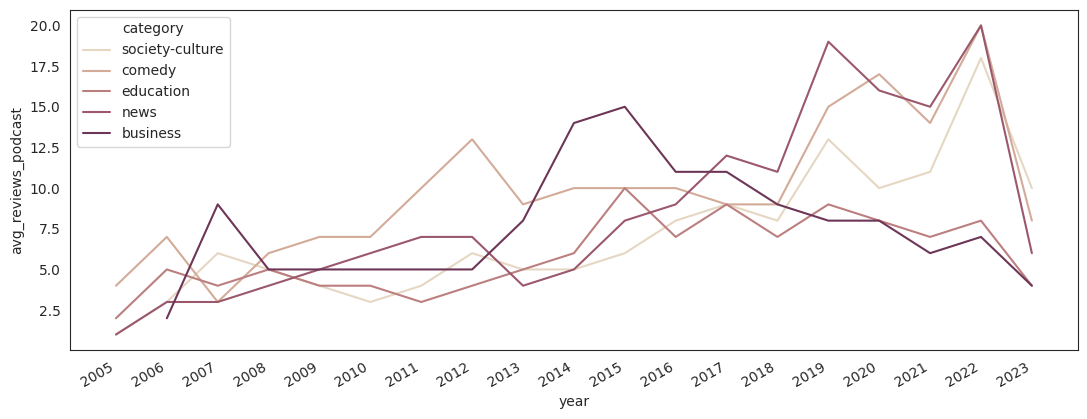

In [73]:
lineplot_grouped("year", "avg_reviews_podcast", "category")

There is a lot more variety in the average amount of reviews a podcast gets between categories and within categories over the years.

(2.0, 5.0)

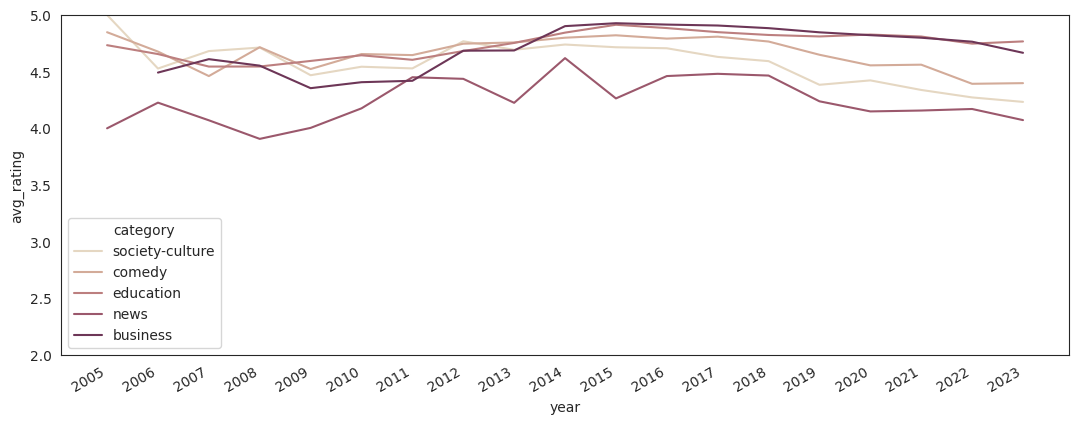

In [74]:
plt.figure(figsize=(13, 5))
sns.lineplot(
    x=top_categories["year"],
    y=top_categories["avg_rating"],
    hue=top_categories["category"],
)
plt.gcf().autofmt_xdate()
plt.ylim(2, 5)

The graphs above focus on the highest volume categories only, to get more detailed insights into other categories, use the dashboard [here](https://lookerstudio.google.com/reporting/1868b3da-f6c9-4913-bce3-90613320b13c/page/p_p0d8qtyjpc).

## Part 3: Statistical analysis
As we saw in the exploratory analysis, 2015 was the year in which the podcasts on itunes were highest rated on average.
After 2015, the quantity of podcasts on itunes grew exponentially until 2020, and then started dropping. In the same period, the average rating score only went down. As we found a moderate negative correlation between average rating score and total number of reviews for years from 2015, we might wonder whether there is a real difference between the average rating scores in 2015 and 2020, as the difference seems very small in absolute terms.
We can theorise that the rating score is an indicator for perceived quality of podcasts on itunes. Therefore, what we are actually wondering is: with increasing volume of podcasts and reviews, did the quality of podcasts on itunes in the US go down in the eyes of the reviewers?

H0: There is no difference in average rating scores between 2015 and 2020.

H1: The average rating score was lower in 2020 than in 2015.

In [75]:
# create data frame with test data only
query_test_data = """
WITH categories_clean AS (
SELECT
distinct podcast_id,
min(category) as cat
FROM categories
group by 1
)
SELECT
rating,
strftime('%Y', created_at) AS year
FROM reviews r
JOIN categories_clean c
ON c.podcast_id = r.podcast_id
WHERE year IN ('2015', '2020')
"""
test_data = pd.read_sql_query(query_test_data, connection)

In [76]:
test_data[["year"]].value_counts()

year
2020    433998
2015     59814
dtype: int64

Assumptions checked:
- Groups to be compared are independent, every review is tied to one date variable, thus one year only.
- Group sizes aren't equal, therefore we take a random sample from the largest to equal the smaller group in size.  
- Normality: the rating scores are deviating from normality, however since we have large samples, the central limit theorem applies.     
- Variance equality to be checked below.


In [77]:
stats_test_data = test_data.groupby("year")["rating"].agg([np.mean, np.var, np.std])
stats_test_data

,mean,var,std
year,,,
2015,4.816,0.521,0.722
2020,4.603,1.183,1.088


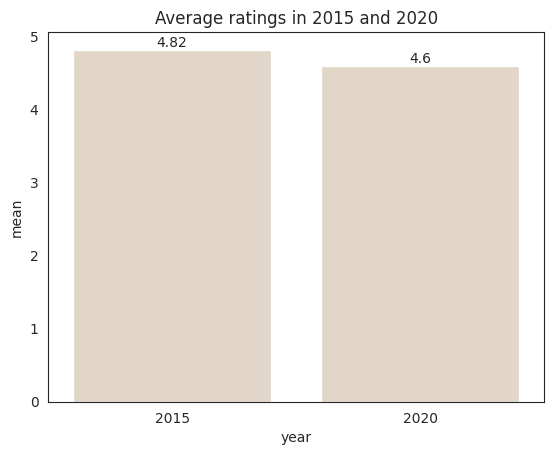

In [78]:
stats_test_data["mean"] = stats_test_data["mean"].round(2)
ax = sns.barplot(x=stats_test_data.index, y=stats_test_data["mean"])
plt.title("Average ratings in 2015 and 2020")
for i, v in enumerate(stats_test_data["mean"]):
    ax.text(i, v, str(v), ha="center", va="bottom", fontsize=10)

We will run an independent samples t-test to test whether the average rating in 2020 is meaningfully lower than in 2015.  

In [79]:
ratings_2015 = test_data[test_data["year"] == "2015"]["rating"]
sample_ratings_2020 = test_data[test_data["year"] == "2020"]["rating"].sample(
    n=59814, random_state=22
)

In [80]:
alpha = 0.05
t_stat, p_value = stats.ttest_ind(
    ratings_2015, sample_ratings_2020, equal_var=False, alternative="greater"
)
std_error = np.sqrt(
    np.var(ratings_2015, ddof=1) / len(ratings_2015)
    + np.var(sample_ratings_2020, ddof=1) / len(sample_ratings_2020)
)
df = len(ratings_2015) + len(sample_ratings_2020) - 2
mean_difference = np.mean(ratings_2015) - np.mean(sample_ratings_2020)
conf_int = stats.t.interval(0.95, df, loc=mean_difference, scale=std_error)
print(f"Difference in Means: {mean_difference:.4f}")
print(
    f"Confidence Interval for the Difference in Means: ({conf_int[0]:.4f}, {conf_int[1]:.4f})\n"
)
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}\n")

Difference in Means: 0.2101
Confidence Interval for the Difference in Means: (0.1996, 0.2205)

t-statistic: 39.50
p-value: 0.0000



Since the p-value is lower than the alpha, we can reject the H0 as we found enough evidence to believe that the mean rating in 2020 is significantly lower than in 2015.
The 95% confidence interval for the difference in means is very narrow, thus we can be confident about the value/point estimate we found for the difference in means.

This result gives us reason to believe that in 2020, podcasts were on average rated lower than in 2015, which could indicate the perceived quality of podcasts went down in the eyes of the reviewers.  
What we could wonder is whether an increase in the amount of reviews leads to a decrease in average rating score, as we had much more reviews in 2020 than in 2015, and we found earlier that those two have  are correlated. However to investigate a causal relation, we would need to do a regression analysis.



## Part 4: Conclusions

* On average, a podcast gets 19 reviews, however there is a lot variety, with amounts of reviews per podcast ranging from 1 to 33k. The latter is exceptional, 75% gets less than 8 reviews.
* The average rating score per podcast is 4.62. Ratings scores are discrete, 87% of the ratings is 5 star, the max. Roughly 6% of the ratings is 1 star, the rest in between.

Categories:
* There are 110 different categories, amongst which main and subcategories. Over the entire dataset, a category on average gets 18575 reviews of 1000 podcasts. Categories have an average rating score between 4.2 and 5.  
* Society-culture, comedy, education, business, news are the categories with the highest amount of reviews.
* True crime has by far the highest amount of reviews per podcast, however those reviews can be both negative and positive, as this category is not having a specifically high average rating.

Time series:
* From 2005 to 2015 the amount of reviews is increasing each year, however not as steeply as between 2015 and 2020, when number of reviews seems to increase exponentially. 2020 is the peak year in number of reviews, afterwards reviews are decreasing year over year.
* The same pattern is seen for the amount of podcasts per year that gets reviewed.
* The most popular categories vary between years, however some categories are large in almost all years, for example comedy, business, sports, arts and education.
* Comedy is top reviewed almost all years, and is also the category with the largest number of podcasts, except between 2020 and 2022 where business is largest.

Average rating and number of reviews seem correlated if the year is taken into account. Before 2015, average rating is higher for categories with more reviews, while after 2015 this correlation turns negative and more reviews does not mean higher average rating any more.

We found out that 2015: the peak year in average rating, and 2020: the peak year in amount of reviews, differed in their average rating with 2015 significantly higher.
Follow up research could focus on investigating whether there is a causal relation between reviews and average rating in the sense that one leads to another, and whether there is a turning point or optimum.  

## Part 5: Limitations and future improvements

Use unaggregated data for dashboard, now it's limited in the amount of graphs that can be created with it. However, the unaggregated data of the review table was too heavy for data studio.

For the time series analysis, the option to analyse monthly data would have been a nice addition to the dashboard.


